In [ ]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c abdous-egg-experiment

100% 736M/736M [00:26<00:00, 36.3MB/s]
100% 736M/736M [00:26<00:00, 29.6MB/s]


In [ ]:
!unzip /content/abdous-egg-experiment.zip

In [ ]:
!mkdir /content/dataset/Test
!mv /content/dataset/test /content/dataset/Test

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB7
from sklearn.utils import shuffle

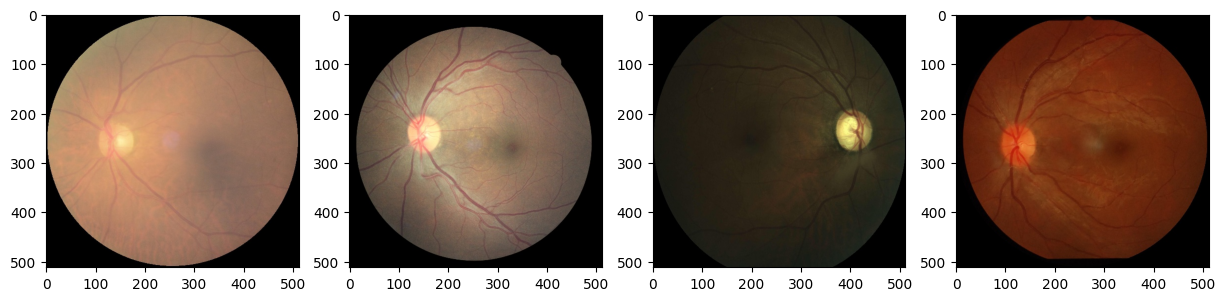

In [ ]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(15,5))
ax1.imshow(plt.imread("/content/dataset/dataset/day_1/1102_left.jpg"))
ax2.imshow(plt.imread("/content/dataset/dataset/day_2/10003_left.jpeg"))
ax3.imshow(plt.imread("/content/dataset/dataset/day_3/1218_right.jpg"))
ax4.imshow(plt.imread("/content/dataset/dataset/day_4/2362_left.jpg"))

plt.show()

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
labels = ['day_1','day_2', 'day_3', 'day_4']

In [ ]:
X_train = []
y_train = []

In [ ]:
for i in labels:
    folderPath = os.path.join('./dataset','dataset',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(img_height, img_width))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
X_train,y_train = shuffle(X_train,y_train,random_state=42)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

In [ ]:
path = "/content/dataset/Test/test"
names = []
images = []
for i in os.listdir(path):
  img = cv2.imread(os.path.join(path,i))
  img = cv2.resize(img,(img_height,img_width))
  img = np.expand_dims(img,axis=0)
  images.append(img)
  names.append(i)
images = np.array(images)

In [ ]:
images_test = images.reshape(-1,img_height,img_width,3)

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
      preprocessing.RandomFlip("horizontal"),
      preprocessing.RandomRotation(0.3),
      preprocessing.RandomHeight(0.2),
      preprocessing.RandomWidth(0.4),
      preprocessing.RandomZoom(0.3),
  ],name="data_augmentation")


In [ ]:
effnet = EfficientNetB7(weights='imagenet', include_top=False)
effnet.trainable = True

In [ ]:
model = models.Sequential()

In [ ]:
inputs = layers.Input(shape=(img_height, img_width, 3), name="input_layer") # shape of input image
inputs= data_augmentation(inputs)
model= effnet(inputs,training=True)
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.35)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=inputs, outputs = model)

In [ ]:
auc = tf.keras.metrics.AUC()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[auc,"accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 efficientnetb7 (Functional  (None, None, None, 2560   64097687  
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 2560)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 4)                 10244     
                                                                 
Total params: 64107931 (244.55 MB)
Trainable params: 63797204

**Next time check the data lenght for each class**

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
hist = model.fit(X_train,y_train,validation_split=0.2,batch_size=32,epochs=2,callbacks=[checkpoint,reduce_lr])

Epoch 1/2
95/95 [==============================] - ETA: 0s - loss: 0.4939 - auc: 0.9581 - accuracy: 0.8334 
Epoch 1: val_accuracy improved from -inf to 0.88816, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


95/95 [==============================] - 2147s 22s/step - loss: 0.4939 - auc: 0.9581 - accuracy: 0.8334 - val_loss: 0.3099 - val_auc: 0.9819 - val_accuracy: 0.8882 - lr: 0.0010
Epoch 2/2
95/95 [==============================] - ETA: 0s - loss: 0.2598 - auc: 0.9867 - accuracy: 0.9055 
Epoch 2: val_accuracy improved from 0.88816 to 0.90395, saving model to best_model.h5
95/95 [==============================] - 2053s 22s/step - loss: 0.2598 - auc: 0.9867 - accuracy: 0.9055 - val_loss: 0.2783 - val_auc: 0.9863 - val_accuracy: 0.9039 - lr: 0.0010


In [ ]:
preds = model.predict(images_test)

14/14 [==============================] - 87s 6s/step


In [ ]:
f_preds = np.argmax(preds,axis=1)

In [ ]:
f_preds

In [ ]:
#change the os.listdir and make so every image have the same index of the numpy array
df = pd.DataFrame({"ID":names,"target":f_preds})

In [ ]:
df["target"]+=1

In [ ]:
df.to_csv("submission.csv",index=False)

In [ ]:
df

,ID,target
0,12536fec-a886-40b0-a448-cfe097f53521.jpg,2
1,06958807-575b-4eca-9079-b3163d6a08b8.jpg,3
2,3be71f0e-ac0f-413f-b1a6-3bdd32192971.jpg,1
3,cfc5d8d1-832a-46c7-a13f-ca1a2d0bea57.jpg,2
4,d0910107-406d-49a2-b724-22df0a42056a.jpg,2
...,...,...
414,c11799f7-483c-4117-8c23-9ff48f63c050.jpg,1
415,385fe4af-3f5c-4b74-96e9-54c43d00099e.jpg,4
416,c2427c6b-ddc7-4c96-9ecf-e41342612c07.jpg,2
417,73dd5b51-1360-4f36-9c86-86b5b666c7bb.jpg,3


In [ ]:
!kaggle competitions submit -c abdous-egg-experiment -f submission.csv -m "message"

100% 17.6k/17.6k [00:00<00:00, 29.3kB/s]
Successfully submitted to Abdou's Egg Experiment